In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Importing necessary libraries
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor,Lambda
from torch.utils.data import DataLoader
import math
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from scipy.signal import savgol_filter

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device being used is {device}")

The device being used is cuda


In [ ]:
## Loading MNIST Data from pytorch
train_data=datasets.MNIST(root="mnist_data",train=True, download=True,transform=ToTensor(),target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_data=datasets.MNIST(root="mnist_data",train=False,download=True,transform=ToTensor(),target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

In [ ]:
print(f"The length of the train set is {len(train_data)}")
print(f"The length of the test set is {len(test_data)}")

The length of the train set is 60000
The length of the test set is 10000


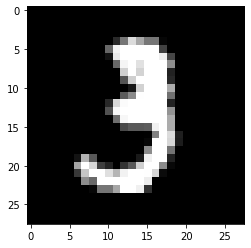

In [ ]:
#Let's look at a sample image 
img,label=train_data[10]
plt.imshow(np.squeeze(img),cmap='gray')

## NN Implementation without AutoGrad

In [ ]:
#User-defined activation functions

def my_sigmoid(X):

  """
    Applies the sigmoid activation function element-wise to the input tensor X.

    Args:
    - X: torch.Tensor of size (batch_size,k)

    Returns:
    - A torch.Tensor of the same shape as X, with the sigmoid function applied element-wise.
  """

  return 1/(1+torch.exp(-X))
  
def my_softmax(X):

  """
    Applies the softmax activation function row-wise to the input tensor X.

    Args:
    - X: torch.Tensor of size (batch_size,k)

    Returns:
    - A torch.Tensor of the same shape as X, with the softmax function applied row-wise.
  """

  X_exp=torch.exp(X)
  row_exp_sum=torch.sum(X_exp, dim=1, keepdim=True)
  return X_exp/row_exp_sum

In [ ]:
#Three-layer network as defined the backprop derivation question (2 Hidden Layers[200&100 neurons] and 1 Output layer)

class MyModel():
  def __init__(self,input_dim=784,layer_1=200,layer_2=100,num_classes=10,device='cpu'):
    #Define the layer weights and move them to the appropriate device that's being used
    d0,d1,d2,k=input_dim,layer_1,layer_2,num_classes
   
    """
    #Initialization for part 2(custom)
    self.W1=torch.from_numpy(np.random.uniform(low=-0.07, high=0.07, size=(d0,d1))).float().to(device)
    self.W2=torch.from_numpy(np.random.uniform(low=-0.07, high=0.07, size=(d1,d2))).float().to(device)
    self.W3=torch.from_numpy(np.random.uniform(low=-0.07, high=0.07, size=(d2,k))).float().to(device)
    """

    """ 
    #Zero Initialization for part 4(a)
    self.W1=torch.zeros(size=(d0,d1)).float().to(device)
    self.W2=torch.zeros(size=(d1,d2)).float().to(device)
    self.W3=torch.zeros(size=(d2,k)).float().to(device)
    """

    #Initialization for part 4(b)
    self.W1=torch.from_numpy(np.random.uniform(low=-1, high=1, size=(d0,d1))).float().to(device)
    self.W2=torch.from_numpy(np.random.uniform(low=-1, high=1, size=(d1,d2))).float().to(device)
    self.W3=torch.from_numpy(np.random.uniform(low=-1, high=1, size=(d2,k))).float().to(device)

  def forward(self,X):
    self.Z1=torch.matmul(X,self.W1)
    self.A1=my_sigmoid(self.Z1)
    self.Z2=torch.matmul(self.A1,self.W2)
    self.A2=my_sigmoid(self.Z2)
    self.Z3=torch.matmul(self.A2,self.W3)
    self.A3=my_softmax(self.Z3)
    return self.A3

In [ ]:
#Custom Loss Implementation 
def my_cross_entropy(Y,A):
  before_sum=Y*torch.log(A)
  return -torch.sum(before_sum,dim=1)

In [ ]:
## Custom train loop with gradient updates calculated in question 3.1
def custom_training(model,train_data,num_epochs=10,batch_size=32,lr=1e-3):
  #Define the train data loader
  train_dataloader=DataLoader(train_data, batch_size=batch_size,shuffle=True)
  loss_dict={}
  for epoch in range(num_epochs):
    avg_loss=0
    for batch, (X,y) in enumerate(train_dataloader):
      X=torch.flatten(torch.squeeze(X),start_dim=1,end_dim=-1)
      X=X.to(device)
      y=y.to(device)
      model_out=model.forward(X)
      train_loss=torch.sum(my_cross_entropy(y,model_out))/batch_size
      avg_loss+=train_loss.item()
      if (batch+1)%100==0:
        loss_dict[(epoch+1)*(batch+1)]=avg_loss/100
        print(f"Epoch:{epoch+1} Step:{batch+1} Train Loss:{avg_loss/100}")
        avg_loss=0
      #Gradients of the weights w.r.t loss 
      dZ3=(model_out-y)
      dW3=torch.matmul(model.A2.T,dZ3)
      dZ2=torch.matmul(dZ3,model.W3.T)*(my_sigmoid(model.Z2)*(1-my_sigmoid(model.Z2)))
      dW2=torch.matmul(model.A1.T,dZ2)
      dZ1=torch.matmul(dZ2,model.W2.T)*(my_sigmoid(model.Z1)*(1-my_sigmoid(model.Z1)))
      dW1=torch.matmul(X.T,dZ1)

      #Updating the weights
      model.W3-=lr*dW3
      model.W2-=lr*dW2
      model.W1-=lr*dW1

  #Displaying training curve 
  x_values=list(loss_dict.keys())
  y_values=list(loss_dict.values())
  y_smooth = savgol_filter(y_values, window_length=10, polyorder=2)
  plt.plot(x_values,y_smooth) 
  plt.xlabel('Number of steps')
  plt.ylabel('Train-Loss')
  #plt.title('Training curve of custom implementation using SGD batch_size=32')
  plt.title('Training curve of custom implementation for random -1 to 1 initialization case using SGD batch_size=32')
  plt.show()

In [ ]:
#Custom testing loop to get accuracy of the predictions of the test set
def custom_testing(model, test_data,batch_size=32):
  test_set_size=len(test_data)
  correct=0
  #Define the test data loader
  test_dataloader=DataLoader(test_data, batch_size=32,shuffle=True)
  for batch,(X,y) in enumerate(test_dataloader):
    X=torch.flatten(torch.squeeze(X),start_dim=1,end_dim=-1)
    y=torch.argmax(y,dim=1)
    X=X.to(device)
    y=y.to(device)
    model_out=model.forward(X.float())
    pred=torch.argmax(model_out,dim=1)
    correct+=(pred==y).sum().item()

  print(f"The test accuracy of the model is {correct*100/test_set_size}%")



Epoch:1 Step:100 Train Loss:1.517290945649147
Epoch:1 Step:200 Train Loss:0.7432381743192673
Epoch:1 Step:300 Train Loss:0.6234972834587097
Epoch:1 Step:400 Train Loss:0.5723619790375233
Epoch:1 Step:500 Train Loss:0.49593134567141534
Epoch:1 Step:600 Train Loss:0.45366644769907
Epoch:1 Step:700 Train Loss:0.41174228981137273
Epoch:1 Step:800 Train Loss:0.44546463310718537
Epoch:1 Step:900 Train Loss:0.37594978511333466
Epoch:1 Step:1000 Train Loss:0.3792925345152616
Epoch:1 Step:1100 Train Loss:0.363908476755023
Epoch:1 Step:1200 Train Loss:0.3253254476189613
Epoch:1 Step:1300 Train Loss:0.34527164075523614
Epoch:1 Step:1400 Train Loss:0.3347506466507912
Epoch:1 Step:1500 Train Loss:0.3825646439939737
Epoch:1 Step:1600 Train Loss:0.3242548584938049
Epoch:1 Step:1700 Train Loss:0.3080693608522415
Epoch:1 Step:1800 Train Loss:0.28449620310217144
Epoch:2 Step:100 Train Loss:0.2458465237170458
Epoch:2 Step:200 Train Loss:0.260443180128932
Epoch:2 Step:300 Train Loss:0.2690815008431673
Epo

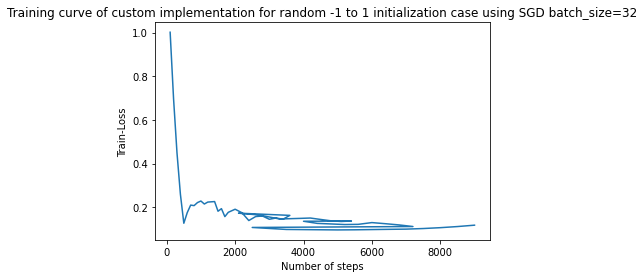

In [ ]:
#Define the hyperparameters
k=10 #Number of classes in the MNIST dataset
hlayer_1=200
hlayer_2=100
input_dim=28*28
batch_size = 32
learning_rate=1e-2


#Loading the train,test data and normalizing it 
train_data_customexp=datasets.MNIST(root="mnist_data",train=True, download=True,target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_data_customexp=datasets.MNIST(root="mnist_data",train=False,download=True,target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
train_mean_customexp=train_data_customexp.data.float().mean()/255
train_std_customexp=train_data_customexp.data.float().std()/255

normalize_and_convert_to_tensor= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean_customexp], std=[train_std_customexp])
])
train_data_customexp.transform=normalize_and_convert_to_tensor
test_data_customexp.transform=normalize_and_convert_to_tensor

#Instantiate the model 
mymodel=MyModel(input_dim,hlayer_1,hlayer_2,k,device)

#Training with batch-size=32 for 1875 iterations(10 full pass of the training dataset)
custom_training(mymodel,train_data_customexp,5,32,1e-2)

In [ ]:
#Custom-Intialization evaluation of model[part 2]
custom_testing(mymodel,test_data_customexp,32)

The test accuracy of the model is 97.64%


In [ ]:
#Zero-Initialization evaluation of model
custom_testing(mymodel,test_data_customexp,32)

The test accuracy of the model is 11.35%


In [ ]:
#Random-Initialization evaluation of model
custom_testing(mymodel,test_data_customexp,32)

The test accuracy of the model is 94.46%


## Pytorch Implementation of the same model

Epoch:1 Step:100 Train Loss:2.296244215965271
Epoch:1 Step:200 Train Loss:2.257266590595245
Epoch:1 Step:300 Train Loss:2.203940556049347
Epoch:1 Step:400 Train Loss:2.107266305685043
Epoch:1 Step:500 Train Loss:1.9464222407341003
Epoch:1 Step:600 Train Loss:1.7090586519241333
Epoch:1 Step:700 Train Loss:1.4008624231815339
Epoch:1 Step:800 Train Loss:1.1572018951177596
Epoch:1 Step:900 Train Loss:0.97918871819973
Epoch:1 Step:1000 Train Loss:0.8392737090587616
Epoch:1 Step:1100 Train Loss:0.7367490911483765
Epoch:1 Step:1200 Train Loss:0.6780733457207679
Epoch:1 Step:1300 Train Loss:0.6128910115361214
Epoch:1 Step:1400 Train Loss:0.5818020692467689
Epoch:1 Step:1500 Train Loss:0.5296454760432243
Epoch:1 Step:1600 Train Loss:0.5214789463579654
Epoch:1 Step:1700 Train Loss:0.5069806669652462
Epoch:1 Step:1800 Train Loss:0.4783239696919918
Epoch:2 Step:100 Train Loss:0.44192604392766954
Epoch:2 Step:200 Train Loss:0.4294471281766892
Epoch:2 Step:300 Train Loss:0.4353902652859688
Epoch:2 S

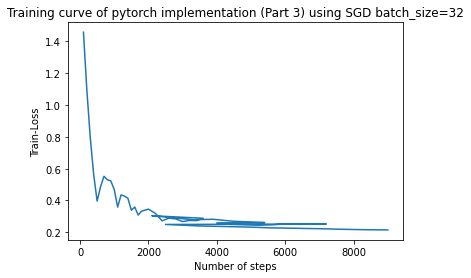

The test accuracy of the model is 91.58%


In [ ]:
# Define the Pytorch impplementation model
class PyTorchModel(nn.Module):
    def __init__(self,input_dim=784,layer_1=200,layer_2=100,num_classes=10):
        super().__init__()
        d0,d1,d2,k=input_dim,layer_1,layer_2,num_classes
        self.W1 = nn.Linear(d0, d1)
        self.W2= nn.Linear(d1, d2)
        self.W3 = nn.Linear(d2, k)
        self.W1.weight.data.uniform_(-0.07,0.07)
        self.W2.weight.data.uniform_(-0.07,0.07)
        self.W3.weight.data.uniform_(-0.07,0.07)

    def forward(self, X):
        X = X.view(-1, 784)  # flatten the input images
        A1= nn.Sigmoid()(self.W1(X))
        A2 = nn.Sigmoid()(self.W2(A1))
        return self.W3(A2)

#Define the hyperparameters
k=10 #Number of classes in the MNIST dataset
hlayer_1=200
hlayer_2=100
input_dim=28*28
batch_size = 32
learning_rate=1e-2

# Download and normalize the MNIST data 
train_data_torch= datasets.MNIST(root='mnist-pytorch', train=True, download=True)
test_data_torch=datasets.MNIST(root="mnist-pytorch",train=False,download=True)
train_mean_torch=train_data_torch.data.float().mean()/255
train_std_torch=train_data_torch.data.float().std()/255
normalize_and_convert_to_tensor= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean_torch], std=[train_std_torch])
])
train_data_torch.transform=normalize_and_convert_to_tensor
test_data_torch.transform=normalize_and_convert_to_tensor

# Instantiate the neural network and optimizer
torchmodel = PyTorchModel(input_dim,hlayer_1,hlayer_2,k)
torchmodel=torchmodel.to(device)
optimizer = torch.optim.SGD(torchmodel.parameters(), lr=learning_rate)

# Train the neural network
loss_dict={}
for epoch in range(5):
    avg_loss = 0.0
    train_dataloader_torch=DataLoader(train_data, batch_size=batch_size,shuffle=True)
    for batch, (X,y) in enumerate(train_dataloader_torch):
        X=X.to(device)
        y=y.to(device)
        model_output= torchmodel(X)
        loss = nn.CrossEntropyLoss()(model_output, y)
        avg_loss += loss.item()
        if (batch+1)%100==0:
          loss_dict[(epoch+1)*(batch+1)]=avg_loss/100
          print(f"Epoch:{epoch+1} Step:{batch+1} Train Loss:{avg_loss/100}")
          avg_loss=0
        
        #Backprop-Update gradients using auto-grad
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#Displaying training curve 
x_values=list(loss_dict.keys())
y_values=list(loss_dict.values())
y_smooth = savgol_filter(y_values, window_length=10, polyorder=2)
plt.plot(x_values,y_smooth) 
plt.xlabel('Number of steps')
plt.ylabel('Train-Loss')
#plt.title('Training curve of custom implementation using SGD batch_size=32')
plt.title('Training curve of pytorch implementation (Part 3) using SGD batch_size=32')
plt.show()

##Test the model
test_set_size=len(test_data_torch)
correct=0
test_dataloader=DataLoader(test_data_torch, batch_size=32,shuffle=True)
for batch,(X,y) in enumerate(test_dataloader):
    X=X.to(device)
    y=y.to(device)
    model_out=torchmodel(X)
    pred=torch.argmax(model_out,dim=1)
    correct+=(pred==y).sum().item()

print(f"The test accuracy of the model is {correct*100/test_set_size}%")